In [1]:
import matplotlib.pyplot as plt
import numpy as np

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


0.26197212320839147


(array([0.00399895, 0.01599578, 0.01999473, 0.03199157, 0.07198103,
        0.12796627, 0.17995256, 0.17595362, 0.21994202, 0.31591672,
        0.41589037, 0.3838988 , 0.37989986, 0.40789248, 0.35590618,
        0.27992621, 0.18795045, 0.13596416, 0.1399631 , 0.0519863 ,
        0.03599051, 0.03599051, 0.01999473, 0.00399895]),
 array([-3.02801195, -2.77794604, -2.52788014, -2.27781424, -2.02774834,
        -1.77768244, -1.52761653, -1.27755063, -1.02748473, -0.77741883,
        -0.52735293, -0.27728702, -0.02722112,  0.22284478,  0.47291068,
         0.72297659,  0.97304249,  1.22310839,  1.47317429,  1.72324019,
         1.9733061 ,  2.223372  ,  2.4734379 ,  2.7235038 ,  2.97356971]),
 <a list of 24 Patch objects>)

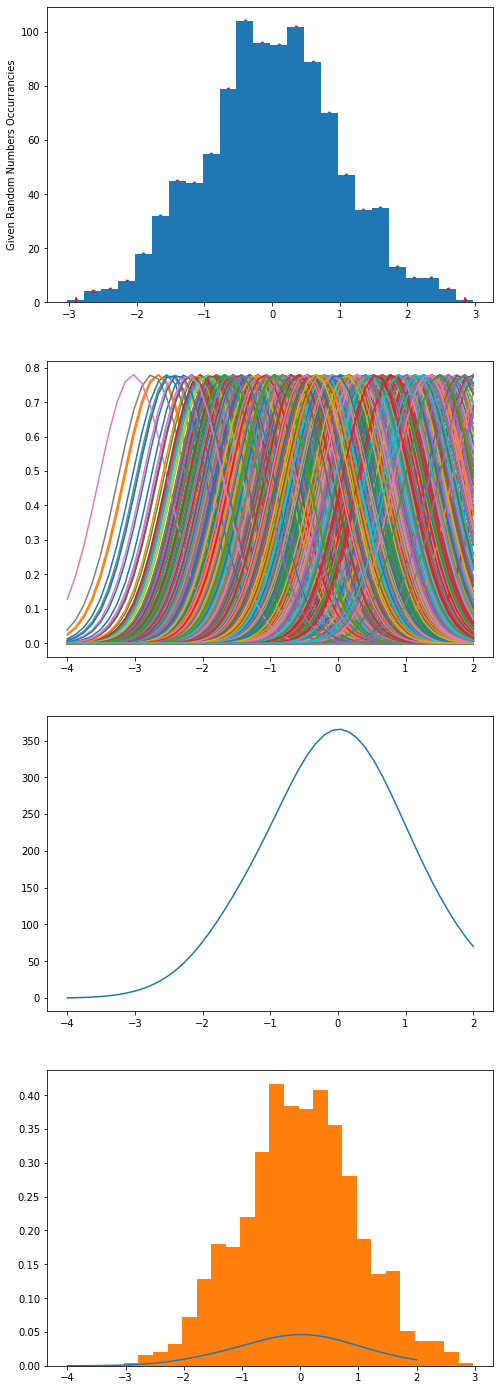

In [2]:
import numpy.random as rd
import math
import scipy as sp
from scipy import integrate
from scipy import stats
mean=0
var=1
x=mean + np.sqrt(var)*rd.randn(1000)

fig,ax=plt.subplots(4,1,figsize=(8,25))
#### 1.1

hst_data=ax[0].hist(x,bins=24)
ax[0].set_ylabel('Given Random Numbers Occurrancies')
ax[0].locator_params(axis='y',integer=True)

unc=np.sqrt(1/hst_data[0])
err_l=(hst_data[1][:-1]+hst_data[1][1:])/2
ax[0].errorbar(err_l,hst_data[0],yerr=unc,fmt='.',ecolor='red',barsabove=True)
#print(err_l)

#### 1.2
stdv=1.06*x.std()*(x.size**(-1/5))
print(stdv)
def NDistr(mn,var):
    xx=np.linspace(np.min(x)//1,np.max(x)//1,50)
    y=[1/np.sqrt(2*math.pi*var)*np.exp(-0.5*(mn-i)**2/var) for i in xx]
    return np.array(y)

xx=np.linspace(np.min(x)//1,np.max(x)//1,50)
tot_gauss=np.zeros((len(xx),1))
for i in x:
    curr_gauss=NDistr(i,stdv)
    ax[1].plot(xx,curr_gauss)
    for k in range(len(tot_gauss)):
        tot_gauss[k]=tot_gauss[k]+curr_gauss[k]
    
#### 3
ax[2].plot(xx,tot_gauss)

#### 4
TG=tot_gauss.reshape(50,1)
XX=xx.reshape(50,1)
# area = integrate.trapz(TG, XX)
area=sum(TG)
norm_sum = tot_gauss/area
ax[3].plot(XX, norm_sum)
#print(area)
ax[3].hist(x, bins = 24, density = True )

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

"wget" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


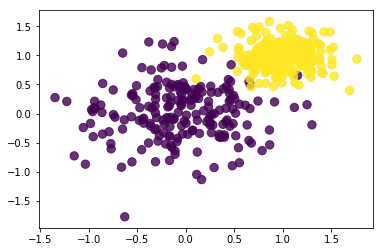

In [3]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

mean and variance for first radom variable are:
mean = 13
variance= [6.60160275]
mean and variance for second radom variable are:
mean = 13
variance= [1.96825895]


Text(0, 0.5, 'y')

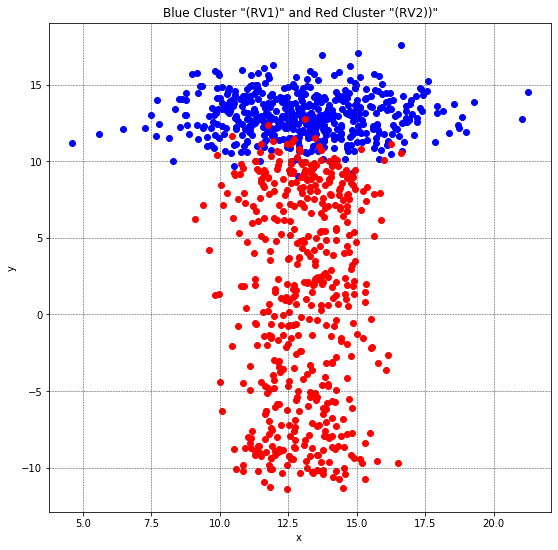

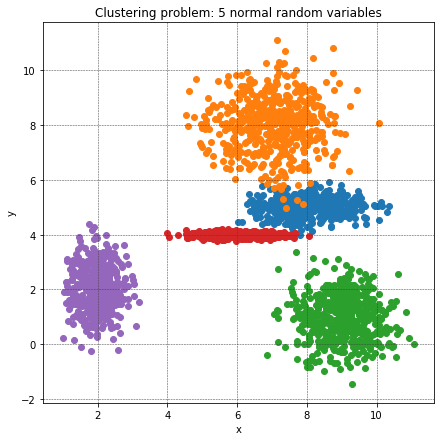

In [20]:
pi=np.pi
m1=rd.randint(10,15)
m2=rd.randint(10,15)
mth_1=pi#/3
mth_2=pi/6
var1=rd.randint(10,20)*rd.random(1)
var2=rd.randint(1,20)*rd.random(1)
N=500

def BiNormal(m_ro,m_th,var_r,var_t,siz):    #data are expressed in polar coordinates
    #ro=m_ro+np.sqrt(var)*rd.randn(size)
    ro=rd.normal(loc=m_ro, scale=var_r, size=siz)
    #th=m_th+np.sqrt(var1)*rd.randn(size)
    th=rd.normal(loc=m_th, scale=var_t, size=siz)
    #RV=np.concatenate((ro,th),axis=0).reshape(siz,2)
    RV=np.array([ro,th])
    return RV

rv1=BiNormal(m1,mth_1,var1,var2,N)
rv2=BiNormal(m2,mth_2,var1,var2,N)

# x1=rv1[0,:]*np.cos(rv1[1,:])
# y1=rv1[0,:]*np.sin(rv1[1,:])
# x2=rv2[0,:]*np.cos(rv2[1,:])
# y2=rv2[0,:]*np.sin(rv2[1,:])

x1=rd.normal(m1,np.sqrt(var1),N)
y1=rd.normal(m1,np.sqrt(var1),N)
x2=rd.normal(m2,np.sqrt(var2),N)
y1=rd.normal(m2,np.sqrt(var2),N)
# x1=np.random.multivariate_normal(m1,var1,N)
# y1=np.random.multivariate_normal(m1,var1,N)
# x2=np.random.multivariate_normal(m2,var2,N)
# y2=np.random.multivariate_normal(m2,var2,N)


fig, ax=plt.subplots(nrows=1,ncols=1,figsize=(9,9))
ax.grid(linestyle="--", linewidth=0.5, color='.25', zorder=-10)
ax.scatter(x1, y1, marker='o', c='b')
ax.scatter(x2, y2, marker='o', c='r')
ax.set_title('Blue Cluster "(RV1)" and Red Cluster "(RV2))"')
fig.gca().set_xlabel('x ')
fig.gca().set_ylabel('y')

print('mean and variance for first radom variable are:')
print('mean = '+str(m1))
print('variance= '+str(var1))
print('mean and variance for second radom variable are:')
print('mean = '+str(m2))
print('variance= '+str(var2))


fig1, ax1=plt.subplots(nrows=1,ncols=1,figsize=(7,7))
for i in range(5):
#     rv=BiNormal(m_ro=rd.randint(1,10),m_th=pi*rd.random(1),var_r=rd.random(1),var_t=rd.random(1),siz=N)
#     rv=rd.normal(rd.randint(1,10),rd.random(1),N)
    x=rd.normal(rd.randint(1,10),rd.random(1),N)#rv[0,:]*np.cos(rv[1,:])
    y=rd.normal(rd.randint(1,10),rd.random(1),N)#rv[0,:]*np.sin(rv[1,:])
    ax1.grid(linestyle="--", linewidth=0.5, color='.25')
    ax1.scatter(x,y,marker='o')
ax1.set_title('Clustering problem: '+str(i+1)+' normal random variables')
fig1.gca().set_xlabel('x')
fig1.gca().set_ylabel('y')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

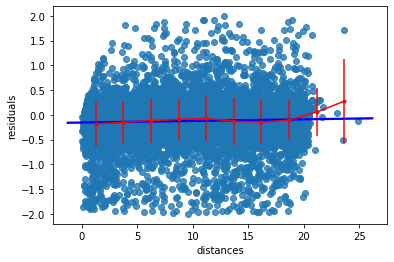

In [19]:
import pandas as pd
from scipy import stats as st
import seaborn as sns

ds = np.load("residuals_261.npy", allow_pickle=True).item()
df=pd.DataFrame(ds)

df= df[np.abs(df['residuals'])<2]
slope, intercept, r_value, p_value, std_err = stats.linregress(df['residuals'], df['distances']) #as defined in scipy.org
sns.regplot("distances", "residuals", data=df, line_kws={'color': 'b'})

Nbin=10
df = df.sort_values(by = 'distances')
dists = df['distances']
bin_length = (np.max(dists) - np.min(dists))/Nbin
division_coordinates = np.array([np.min(dists) + bin_length*i for i in range(1,Nbin) ])
indexes = np.digitize(dists,division_coordinates)     #index of bin in which every sample is inserted

margins = np.histogram_bin_edges(dists,Nbin)
x = (margins[:-1]+ margins[1:])/2 
df['bin_index'] = indexes

y = [] 
std = []
for i in range(Nbin):
    res_i = df[ df['bin_index'] == i]['residuals']
    mean = np.mean(res_i)
    y.append(mean)
    std.append(np.std(res_i))
    
y = np.array(y)
std = np.array(std)

plt.errorbar(x = x,y =y , yerr = std, marker = '.', color = 'r');